In [2]:
import pandas as pd
import glob
import collections
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
import pickle as pkl
import numpy as np
import pprint
import re
from tqdm import tqdm


In [3]:
def ptn_label_load():
    ptn_paths = "PTN共有_保振ホール決済/NPL-68_設計書種別ラベリング_試験用ラベル追加.csv"
    return pd.read_csv(ptn_paths, skiprows=1)

ptn_df = ptn_label_load()
use_category = "設計書種別(試験用)" # "設計書種別" or "設計書種別(再整理)" or "設計書種別(試験用)"
ptn_df = ptn_df[(ptn_df[use_category].notna())]
len(ptn_df)

def convert_df(x):
    label = x[use_category]
    path = "/".join(x["ALL"].split("/")[6:])+x["title"]
    return (label, path)

data_list = ptn_df.apply(convert_df, axis=1).tolist()

data_dict = {}
for data in data_list:
    if data[0] in data_dict.keys():
        data_dict[data[0]].append(data[1])
    else:
        data_dict[data[0]] = [data[1]]
del data_dict["nolabel"]
# del data_dict["画面(JavaScript)"]
[print(f"class: {key}, データ数:{len(data_dict[key])}") for key in data_dict.keys()]
print(f"Total: {len(data_list)}")

/var/folders/rp/bwxtsw2d1kg3s67q9jnsnly52sglqb/T/ipykernel_30855/2668232990.py:3: DtypeWarning: Columns (24,25,26,27,28,29,30,31,32,33,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(ptn_paths, skiprows=1)


class: AQ定義, データ数:37
class: IF定義, データ数:4
class: DBテーブル, データ数:11
class: メッセージ一覧, データ数:5
class: CSVレイアウト(画面), データ数:5
class: 電文レイアウト, データ数:6
class: 画面, データ数:231
class: 画面遷移図, データ数:24
class: 帳票レイアウト, データ数:8
class: CRUD図, データ数:6
class: プログラム設計, データ数:1911
class: 画面レイアウト, データ数:80
class: 千手定義, データ数:52
Total: 2535


## Tokenize

In [5]:
import mojimoji
import MeCab
m = MeCab.Tagger("-Owakati")

from transformers import AutoTokenizer, AutoModelForPreTraining, AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("izumi-lab/electra-base-japanese-discriminator")


In [25]:
def normalize_text(text):
    result = mojimoji.han_to_zen(text)
    result = mojimoji.zen_to_han(result, kana=False)
    result.translate(str.maketrans({chr(0xFF01 + i): chr(0x21 + i) for i in range(94)}))
    return result

def text_to_words(text):
    #text = normalize_text(text)
    m_text = tokenizer.tokenize(text)
    return m_text


def text_to_phrase(text):
    return " ".join(text.split("/"))



In [47]:
corpus_words = []
corpus_phrase = []
corpus_origin = []
target_label = []

label_dic = {}
label2idx = {}
for ind, label in enumerate(data_dict.keys()):
    label_dic[ind+1] = label
    label2idx[label] = ind+1


for key in data_dict.keys():
    for item in data_dict[key]:
        text = normalize_text(item)
        # corpus_words.append(text_to_words(text))
        # corpus_phrase.append(text_to_phrase(text))
        corpus_origin.append(text)
        target_label.append(label2idx[key])



print(label_dic)
target_label[:20]

{1: 'AQ定義', 2: 'IF定義', 3: 'DBテーブル', 4: 'メッセージ一覧', 5: 'CSVレイアウト(画面)', 6: '電文レイアウト', 7: '画面', 8: '画面遷移図', 9: '帳票レイアウト', 10: 'CRUD図', 11: 'プログラム設計', 12: '画面レイアウト', 13: '千手定義'}


[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [48]:
# 未知後の検出
unk_flag = False
unk_words = []
for ind in tqdm(range(len(corpus_words))):
    sub_words = corpus_words[ind]
    origin_words = corpus_phrase[ind]
    for subw in sub_words:
        if subw in origin_words:
            if unk_flag:
                unk_word = origin_words.split(subw, 1)[0]
                origin_words = origin_words.split(subw, 1)[-1]
                unk_words.append(unk_word)
            else:
                origin_words = origin_words.split(subw, 1)[-1]
            
        elif "#" in subw:
            subw_ = re.sub("#", "", subw)
            origin_words = origin_words.split(subw_, 1)[-1]
        elif "[UNK]" == subw:
            unk_flag = True

unk_words = list(set(unk_words))

print(len(unk_words))
for x in unk_words:
    print(x)


0it [00:00, ?it/s]

0


In [49]:
tokenizer = AutoTokenizer.from_pretrained("izumi-lab/electra-base-japanese-discriminator")
model = AutoModelForSequenceClassification.from_pretrained("izumi-lab/electra-base-japanese-discriminator", num_labels=13)

Some weights of the model checkpoint at izumi-lab/electra-base-japanese-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at izumi-lab/electra-base-japanese-discriminator and are newly ini

In [51]:
model.eval()
with torch.no_grad():
    for words in corpus_origin[:5]:
        text = "".join(words)
        inputs = tokenizer.encode(text, return_tensors="pt",padding=True, truncation=True)
        outputs = model(inputs)
        logits = outputs.logits
        print(f"{label_dic[logits.argmax(1).item()]}:{text}")

CRUD図:310_[ST]ホール決済/030 外部設計/020 インターフェース関連/01_AQ・IFレイアウト/01_AQ関連/01_STAR内部/02_受信/AQ_003_国内株式約定済連絡データ(WADKGV00/WADSGV00/WADKGV20).xls
CRUD図:310_[ST]ホール決済/030 外部設計/020.インターフェース関連/01_AQ・IFレイアウト/01_AQ関連/01_STAR内部/02_受信/(ST)(WAF)001_WAFYIK00_外国株式約定データ.xlsx
CRUD図:310_[ST]ホール決済/030 外部設計/020.インターフェース関連/01_AQ・IFレイアウト/01_AQ関連/01_STAR内部/02_受信/(ST)(WAF)003_WAFYIT00_外国投信約定データ.xlsx
CRUD図:310_[ST]ホール決済/030 外部設計/020.インターフェース関連/01_AQ・IFレイアウト/01_AQ関連/01_STAR内部/02_受信/(ST)(WAF)004_WAFGIK00_外国株式約定済連絡データ.xls
CRUD図:310_[ST]ホール決済/030 外部設計/020.インターフェース関連/01_AQ・IFレイアウト/01_AQ関連/01_STAR内部/02_受信/(ST)(WAF)007_WAFDIK00_外国株式出来連絡データ.xls


In [52]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(corpus_origin, target_label, test_size=0.3, shuffle=True, random_state=0, stratify=target_label)
y_train[:15]

[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 7, 11]

In [53]:
x_train, x_test, y_train, y_test = x_train[:20], x_test[:20], y_train[:20], y_test[:20]

In [54]:
y_train

[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 7, 11, 11, 11, 11, 11, 11]

In [55]:
from transformers import AdamW
optimizer = AdamW(model.parameters(), lr=1e-5)
model.train()
epochs = 10
losses = []

model.train()
#再学習
for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    inputs = tokenizer.batch_encode_plus(x_train, return_tensors="pt", padding=True, truncation=True)
    outputs = model(**inputs, labels=torch.tensor(y_train))
    logits = outputs.logits
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    losses.append(loss)
    print(f"epoch:{epoch+1}, loss:{loss}")

/usr/local/var/pyenv/versions/3.9.5/envs/search-engine/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
 10%|█         | 1/10 [00:09<01:26,  9.58s/it]

epoch:1, loss:2.680373430252075


 20%|██        | 2/10 [00:18<01:12,  9.04s/it]

epoch:2, loss:nan


 30%|███       | 3/10 [00:26<01:02,  8.89s/it]

epoch:3, loss:nan


 40%|████      | 4/10 [00:37<00:57,  9.54s/it]

epoch:4, loss:nan


 50%|█████     | 5/10 [00:46<00:47,  9.42s/it]

epoch:5, loss:nan


 60%|██████    | 6/10 [00:54<00:35,  8.89s/it]

epoch:6, loss:nan


 70%|███████   | 7/10 [01:02<00:25,  8.45s/it]

epoch:7, loss:nan


 80%|████████  | 8/10 [01:09<00:16,  8.20s/it]

epoch:8, loss:nan


 90%|█████████ | 9/10 [01:17<00:08,  8.16s/it]

epoch:9, loss:nan


100%|██████████| 10/10 [01:25<00:00,  8.54s/it]

epoch:10, loss:nan


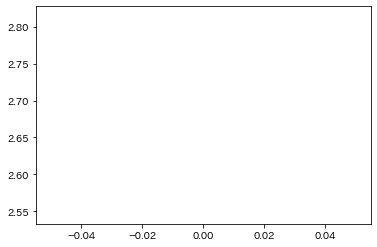

In [56]:
# 学習過程の表示
plt.plot(losses)

In [61]:
model.eval()
preds = []
with torch.no_grad():
    for index, words in enumerate(x_test):
        text = "".join(words)
        inputs = tokenizer.encode(text, return_tensors="pt",padding=True, truncation=True)
        outputs = model(inputs)
        logits = outputs.logits
        pred=logits.argmax(1).item()
        preds.append(pred)
        #print(f"{label_dic[logits.argmax(1).item()+1]}:{label_dic[y_test[index]]}, input: {text}, ")
        print(f"{label_dic[logits.argmax(1).item()+1]}:{label_dic[y_test[index]]}")

AQ定義:プログラム設計
AQ定義:プログラム設計
AQ定義:プログラム設計
AQ定義:プログラム設計
AQ定義:プログラム設計
AQ定義:プログラム設計
AQ定義:プログラム設計
AQ定義:プログラム設計
AQ定義:プログラム設計
AQ定義:プログラム設計
AQ定義:画面遷移図
AQ定義:プログラム設計
AQ定義:プログラム設計
AQ定義:プログラム設計
AQ定義:プログラム設計
AQ定義:画面レイアウト
AQ定義:プログラム設計
AQ定義:プログラム設計
AQ定義:プログラム設計
AQ定義:画面遷移図
